In [1]:
import os
import re
import sys
import numpy as np
import torch
import random
from tqdm.auto import tqdm
import networkx as nx
from torch_geometric import datasets
from torch_geometric.utils import to_networkx
from torch_geometric.utils.convert import from_networkx
import matplotlib.pyplot as plt
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import InMemoryDataset
from collections import defaultdict, Counter

In [13]:
class DatasetGenerator:
    def __init__(self):
        self.sample_path = 'RWDataset/samples/samples.pt'
        self.sample_gt_path = 'RWDataset/samples/samples_gt5.pt'
        self.sample_train_path = 'RWDataset/samples/samples_gt5_train.pt'
        self.sample_val_path = 'RWDataset/samples/samples_gt5_val.pt'
        self.sample_test_path = 'RWDataset/samples/samples_gt5_test.pt'
        self.sample_with_features_path = 'RWDataset/samples/samples_features.pt'
        self.many_small_graph_path = 'RWDataset/many_small/graph.pt'
        self.many_small_desco_path = 'RWDataset/many_small/desco.pt'

        # Note: the ego network used in DeSCo contains only nodes having index < central node index
        self.edgelist_graph_path = 'RWDataset/edgelist_graph'
        self.edgelist_desco_path = 'RWDataset/edgelist_desco'
        self.evoke_wrappers_path = 'evoke/wrappers'
        self.run_evoke_name = 'run_evoke.py'
        
    # 1. Download the datasets, sample and save to file
    def download_sample(self, num_each_size=20, max_size=1000, visualize=False):
        # list and download all datasets manually
        # ['dblp_ct1', 'dblp_ct2', 'DBLP_v1', 'facebook_ct1', 'facebook_ct2', 'highschool_ct1', 'highschool_ct2', 'infectious_ct1', 'infectious_ct2', 'mit_ct1', 'mit_ct2', 'tumblr_ct1', 'tumblr_ct2'] in 'social networks' cannot be processed
        tudataset = {
            'molecules': ['AIDS', 'alchemy_full', 'aspirin', 'benzene', 'BZR', 'BZR_MD', 'COX2', 'COX2_MD', 'DHFR', 'DHFR_MD', 'ER_MD', 'ethanol', 'FRANKENSTEIN', 'malonaldehyde', 'MCF-7', 'MCF-7H', 'MOLT-4', 'MOLT-4H', 'Mutagenicity', 'MUTAG', 'naphthalene', 'NCI1', 'NCI109', 'NCI-H23', 'NCI-H23H', 'OVCAR-8', 'OVCAR-8H', 'P388', 'P388H', 'PC-3', 'PC-3H', 'PTC_FM', 'PTC_FR', 'PTC_MM', 'PTC_MR', 'QM9', 'salicylic_acid', 'SF-295', 'SF-295H', 'SN12C', 'SN12CH', 'SW-620', 'SW-620H', 'toluene', 'Tox21_AhR_training', 'Tox21_AhR_testing', 'Tox21_AhR_evaluation', 'Tox21_AR_training', 'Tox21_AR_testing', 'Tox21_AR_evaluation', 'Tox21_AR-LBD_training', 'Tox21_AR-LBD_testing', 'Tox21_AR-LBD_evaluation', 'Tox21_ARE_training', 'Tox21_ARE_testing', 'Tox21_ARE_evaluation', 'Tox21_aromatase_training', 'Tox21_aromatase_testing', 'Tox21_aromatase_evaluation', 'Tox21_ATAD5_training', 'Tox21_ATAD5_testing', 'Tox21_ATAD5_evaluation', 'Tox21_ER_training', 'Tox21_ER_testing', 'Tox21_ER_evaluation', 'Tox21_ER-LBD_training', 'Tox21_ER-LBD_testing', 'Tox21_ER-LBD_evaluation', 'Tox21_HSE_training', 'Tox21_HSE_testing', 'Tox21_HSE_evaluation', 'Tox21_MMP_training', 'Tox21_MMP_testing', 'Tox21_MMP_evaluation', 'Tox21_p53_training', 'Tox21_p53_testing', 'Tox21_p53_evaluation', 'Tox21_PPAR-gamma_training', 'Tox21_PPAR-gamma_testing', 'Tox21_PPAR-gamma_evaluation', 'UACC257', 'UACC257H', 'uracil', 'Yeast', 'YeastH', 'ZINC_full'],
            'bioinformatics': ['DD', 'ENZYMES', 'KKI', 'OHSU', 'Peking_1', 'PROTEINS'],
            'computer vision': ['COIL-DEL', 'COIL-RAG', 'Cuneiform', 'Fingerprint', 'Letter-high', 'Letter-low', 'Letter-med', 'MSRC_9', 'MSRC_21', 'MSRC_21C', 'FIRSTMM_DB'],
            'social networks': ['COLLAB', 'deezer_ego_nets', 'github_stargazers', 'IMDB-BINARY', 'IMDB-MULTI', 'REDDIT-BINARY', 'REDDIT-MULTI-5K', 'REDDIT-MULTI-12K', 'reddit_threads', 'twitch_egos', 'TWITTER-Real-Graph-Partial'],
            'synthetic': ['COLORS-3', 'SYNTHETICnew', 'Synthie', 'TRIANGLES']
        }
        planetoid = ['Cora', 'CiteSeer', 'PubMed']
        ogb = ['ogbg-molhiv', 'ogbg-molpcba', 'ogbg-ppa']

        graph_size = []

        # molecule datasets
        for name in tudataset['molecules']:
            dataset = datasets.TUDataset(root='download/TUDataset', name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)
        for name in ogb[:2]:
            dataset = PygGraphPropPredDataset(name=name, root='download/OGB')
            for graph in (tqdm(dataset)):
                graph_size.append(graph.num_nodes)

        # bioinformatics datasets
        for name in tudataset['bioinformatics']:
            dataset = datasets.TUDataset(root='download/TUDataset', name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)
        dataset = PygGraphPropPredDataset(name=ogb[2], root='download/OGB')
        for graph in tqdm(dataset):
            graph_size.append(graph.num_nodes)

        # computer vision datasets
        for name in tudataset['computer vision'][-4:]:
            dataset = datasets.TUDataset(root='download/TUDataset', name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)

        # social networks datasets
        for name in tudataset['social networks'][:-1]:
            dataset = datasets.TUDataset(root='download/TUDataset', name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)

        # citation networks datasets
        for name in planetoid:
            dataset = datasets.Planetoid(root='download/Planetoid', name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)

        # compute the number of graphs for each node size
        graph_size_count = [0] * max(graph_size)
        for size in graph_size:
            if size > 0:
                graph_size_count[size - 1] += 1
        sample_p = [0] * (max_size + 1)
        for i in range(max_size):
            if graph_size_count[i] > 0:
                sample_p[i + 1] = min(num_each_size * 5 / graph_size_count[i], 1)

        graphs_selected = [[] for _ in range(max_size + 1)]

        # sample molecule graphs
        for name in tudataset['molecules']:
            dataset = datasets.TUDataset(root='download/TUDataset', name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    # push the graph to the list with probability sample_p[graph.num_nodes]
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'molecules'))
        for name in ogb[:2]:
            dataset = PygGraphPropPredDataset(name=name, root='download/OGB')
            for graph in (tqdm(dataset)):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'molecules'))

        # sample bioinformatics graphs
        for name in tudataset['bioinformatics']:
            dataset = datasets.TUDataset(root='download/TUDataset', name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'bioinformatics'))
        dataset = PygGraphPropPredDataset(name=ogb[2], root='download/OGB')
        for graph in tqdm(dataset):
            if 0 < graph.num_nodes <= max_size:
                if torch.rand(1).item() < sample_p[graph.num_nodes]:
                    graphs_selected[graph.num_nodes].append((graph, 'bioinformatics'))

        # sample computer vision graphs
        for name in tudataset['computer vision'][-4:]:
            dataset = datasets.TUDataset(root='download/TUDataset', name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'computer vision'))

        # sample social networks graphs
        for name in tudataset['social networks'][:-1]:
            dataset = datasets.TUDataset(root='download/TUDataset', name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'social networks'))

        # sample citation networks graphs
        for name in planetoid:
            dataset = datasets.Planetoid(root='data/Planetoid', name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'citation networks'))

        # randomly select num_each_size graphs for each size i
        graphs_selected_copy = graphs_selected.copy()
        for i in range(1, max_size + 1):
            if len(graphs_selected_copy[i]) > num_each_size:
                graphs_selected_copy[i] = [graphs_selected_copy[i][j] for j in torch.randperm(len(graphs_selected_copy[i]))[:num_each_size]]

        # draw the picture for number of graphs of each size
        if visualize:
            fig, axs = plt.subplots(1, 1)
            axs.bar(range(0, max_size+1), [len(graphs_selected_copy[i]) for i in range(max_size+1)])
            axs.set_xlabel('Number of nodes')
            axs.set_ylabel('Number of graphs')
            axs.set_title('Number of graphs of each size')
            plt.show()

        # convert the graphs to torch_geometric.data.Data object
        graphs_nx = [to_networkx(d[0], to_undirected=True, remove_self_loops=True) for i in range(1, max_size+1) for d in graphs_selected_copy[i]]
        graphs_pyg = [from_networkx(g.subgraph(max(nx.connected_components(g), key=len))) for g in graphs_nx]
        domains = [d[1] for i in range(1, max_size+1) for d in graphs_selected_copy[i]]
        for i, g in enumerate(graphs_pyg):
            g.domain = domains[i]
        # remove all the graphs with 0 edge
        graphs_pyg = [g for g in graphs_pyg if g.num_edges > 0]
        # keep only 1 graph with num_nodes=2 and num_edges=1
        graphs_pyg = graphs_pyg[:1] + [g for g in graphs_pyg[1:] if not (g.num_nodes == 2 and g.num_edges == 2)]

        # save the graphs to file
        torch.save(graphs_pyg, self.sample_path)
        
    # 2. generate the ground truth for all graphs sampled and split the dataset into train, val and test
    def ground_truth(self):
        if not os.path.exists(self.sample_path):
            print('No sample file found! Start to download and sample...')
            self.download_sample()            
        graphs = torch.load(self.sample_path)
        print('Number of graphs sampled: ', len(graphs))
        
        # use EVOKE to compute ground truth
        # 2.1 generate edge_list files EVOKE needs 
        for i, g in tqdm(enumerate(graphs), total=len(graphs)):
            with open(f'{self.edgelist_graph_path}/rw_{i}.edgelist', 'w') as f:
                f.write(f'{g.num_nodes} {g.num_edges//2}\n')
                for edge in g.edge_index.T:
                    if edge[0] < edge[1]:
                        f.write(f'{edge[0]} {edge[1]}\n')
        print('Edge list files generated')

        # 2.2 compute the ground truth using 'run_ego.py' with EVOKE
        # move the edgelist folder to evoke/wrappers
        os.system(f'mv {self.edgelist_graph_path} {self.evoke_wrappers_path}')
        # change directory to wrappers and run the 'run_ego.py' to compute the ground truth
        # NOTE: used ORCA & graph match in old version
        os.system(f'cd {self.evoke_wrappers_path} && python {self.run_evoke_name} graph')
        # read in the ground truth and add gt_induced_le5 & gt_noninduced_le5 to the graphs
        noninduced = torch.load(f'{self.evoke_wrappers_path}/noninduced_graph.pt')
        induced = torch.load(f'{self.evoke_wrappers_path}/induced_graph.pt')
        start_pos = 0
        for g in graphs:
            g.gt_noninduced_le5 = noninduced[start_pos:start_pos+g.num_nodes]
            g.gt_induced_le5 = induced[start_pos:start_pos+g.num_nodes]
            start_pos += g.num_nodes
        # save the ground truth to file
        torch.save(graphs, self.sample_gt_path)
        print(f'Ground truth computed and saved to {self.sample_gt_path}')
        
        # 2.3 split the dataset into train, val, test
        size_split = defaultdict(list)
        for i, g in enumerate(graphs):
            size_split[min(g.num_nodes // 100, 9)].append(i)
        
        train, val, test = [], [], []
        for temp in size_split.values():
            random.shuffle(temp)
            n = len(temp)
            split1, split2 = n // 2, n // 2 + n // 5
            train.extend(temp[:split1])
            val.extend(temp[split1:split2])
            test.extend(temp[split2:])
        
        train.sort()
        val.sort()
        test.sort()
        # save the datasets to files
        torch.save([graphs[i] for i in train], self.sample_train_path)
        torch.save([graphs[i] for i in val], self.sample_val_path)
        torch.save([graphs[i] for i in test], self.sample_test_path)
        print(f'Dataset split into train, val, test and saved to files')

    # 3. visualize the split dataset(train, val, test) if needed
    def visualize_graphs(self, file_path=None):
        # print the current folder path
        print(os.getcwd())
        if file_path is None:
            file_path = self.sample_gt_path
        graphs = torch.load(file_path)
        print('Data loaded, total number of graphs: ', len(graphs))

        # features of the graphs: (#node, #edge, domain) as key, #that graph as value
        features = Counter([(g.num_nodes, g.num_edges, g.domain) for g in graphs])
        # convert the features to list
        features_list = [(key[0], key[1], key[2], value) for key, value in features.items()]

        domains = ['molecules', 'bioinformatics', 'computer vision', 'social networks']
        # set different shapes for different domains
        shapes = ['o', '*', 'D', 's']
        # use colormap 'Set3' to represent the domain
        # cmap = plt.colormaps['Set1']
        cmap = ['red', 'green', 'blue', 'purple']
        size_times = [0.5, 50, 50, 2]

        fig, axs = plt.subplots(1, 4, figsize=(20, 4))
        for index, domain in enumerate(domains):
            x = [f[0] for f in features_list if f[2] == domain]
            y = [f[1] for f in features_list if f[2] == domain]
            s = [size_times[index]*f[3]**2 for f in features_list if f[2] == domain]
            axs[index].scatter(x, y, marker=shapes[index], label=domain, color=cmap[index], s=s, alpha=0.3)
            axs[index].legend()
        # set the x-axis and y-axis labels for the whole figure
        fig.text(0.5, 0.01, 'num_nodes', ha='center')
        fig.text(0.1, 0.5, 'num_edges', va='center', rotation='vertical')

        features_list_no_count = []
        for key, value in features.items():
            for _ in range(value):
                features_list_no_count.append(key)
        color_scheme2 = ['red', 'green', 'blue', 'purple']
        fig, axs = plt.subplots(1, 1, figsize=(12, 4))
        for index, domain in enumerate(domains):
            x = [f[0] for f in features_list_no_count if f[2] == domain]
            y = [f[1] for f in features_list_no_count if f[2] == domain]
            axs.scatter(x, y, marker=shapes[index], label=domain, color=color_scheme2[index], s=0.55, alpha=0.5)
            axs.legend()
        # set the x-axis and y-axis labels for the whole figure
        fig.text(0.5, 0.01, 'num_nodes', ha='center')
        fig.text(0.06, 0.5, 'num_edges', va='center', rotation='vertical')

        # draw the dot plot with x-axis=domain, y-axis=num_nodes/num_edges/density of the graphs in graphs_pyg
        fig, axs = plt.subplots(1, 3, figsize=(18, 4))
        axs[0].scatter([f[2] for f in features_list_no_count], [f[0] for f in features_list_no_count], s=0.1, alpha=0.8)
        axs[0].set_ylabel('num_nodes')
        axs[0].set_xlabel('domain')
        axs[1].scatter([f[2] for f in features_list_no_count], [f[1] for f in features_list_no_count], s=0.1, alpha=0.8)
        axs[1].set_ylabel('num_edges')
        axs[1].set_xlabel('domain')
        axs[2].scatter([f[2] for f in features_list_no_count], [f[1]/f[0] for f in features_list_no_count], s=0.1, alpha=0.8)
        axs[2].set_ylabel('density')
        axs[2].set_xlabel('domain')

        # draw the graph to show the distribution of the graph node size, edge size, and density
        fig, axs = plt.subplots(1, 3, figsize=(18, 4))
        node_size_distribution = [0 for _ in range(1001)]
        edge_size_distribution = {}
        density_distribution = {}
        for f in features_list:
            node_size_distribution[f[0]] += f[3]
            edge_size_distribution[f[1]] = edge_size_distribution.get(f[1], 0) + f[3]
            density = f[1] // f[0]
            density_distribution[density] = density_distribution.get(density, 0) + f[3]

        axs[0].hist([x[0] for x in features_list_no_count], bins=10, linewidth=0.5, edgecolor='black')
        axs[0].set_xlabel('num_nodes')
        axs[0].set_ylabel('count')
        # set the x-axis as log scale
        axs[1].hist([x[1]//2 for x in features_list_no_count], bins=100, linewidth=0.5, edgecolor='black')
        axs[1].set_xlabel('num_edges')
        axs[1].set_ylabel('count')
        # set the x-axis and y-axis as log scale
        axs[2].hist([x[1]//2/x[0] for x in features_list_no_count], bins=50, linewidth=0.5, edgecolor='black')
        axs[2].set_xlabel('density')
        axs[2].set_ylabel('count')

        # node-layer features
        pattern_dis_induced = torch.cat([g.gt_induced_le5.T for g in graphs], dim=1)
        print('pattern_dis_induced shape: ', pattern_dis_induced.shape)
        fig, axs = plt.subplots(5, 6, figsize=(24, 20))
        for i, ax in enumerate(axs.flatten()):
            ax.hist(pattern_dis_induced[i].numpy(), bins=10, linewidth=0.5, edgecolor='black')
            ax.set_yscale('log')
            ax.set_title(f'pattern {i}')
        
    # 4. sample graphs again from the sampled dataset to generate the dataset for GNN methods(except DeSCo)
    def sample_gnn_dataset(self):
        if not os.path.exists(self.sample_gt_path):
            print('No ground truth file found! Start to compute the ground truth...')
            self.ground_truth()
        graphs = torch.load(self.sample_gt_path)
        print('Dataset with ground truth loaded, total number of graphs: ', len(graphs))

        # sample 1200/300/150 graphs in the regions respectively as MSS, MSM, and MSL
        index_200 = list(map(lambda x: x.num_nodes >= 200, graphs)).index(True)
        index_600 = list(map(lambda x: x.num_nodes >= 600, graphs)).index(True)
        MSS = random.sample(graphs[:index_200], 1200)
        MSM = random.sample(graphs[index_200:index_600], 300)
        MSL = random.sample(graphs[index_600:], 150)
        
        # save the datasets to files
        # Note: not split into train, val and test, users can do this with their own split strategy. Checked that if split into 4:1:1, the sum of num_nodes in each part is also close to 4:1:1
        torch.save((MSS, MSM, MSL), self.many_small_graph_path)
        print(f'Dataset with MSS, MSM, MSL saved to {self.many_small_graph_path}')

    # 5. generate the dataset for DeSCo
    def generate_desco_dataset(self):
        if not os.path.exists(self.many_small_graph_path):
            print('No GNN dataset file found! Start to sample the GNN dataset...')
            self.sample_gnn_dataset()
        graphs = torch.load(self.many_small_graph_path)
        print('GNN dataset loaded, total number of graphs: ', [len(ms) for ms in graphs])
        
        # 5.1 for each graph in graphs, get desco-egonetwork around each node and combine them into a whole graph
        graphs_nx = [to_networkx(g, to_undirected=True) for ms in graphs for g in ms]
        ego_4h_graphs = []
        for g in tqdm(graphs_nx):
            ego_4h_g = []
            for node in g.nodes:
                ego_full = nx.ego_graph(g, node, radius=4)
                # delete nodes with index larger than node
                for n in list(ego_full.nodes):
                    if n > node:
                        ego_full.remove_node(n)
                # get the connected components of the ego graph and select the one contains the node
                connected_components = list(nx.connected_components(ego_full))
                for cc in connected_components:
                    if node in cc:
                        ego_full = ego_full.subgraph(cc)
                        break
                ego_4h_g.append(ego_full)
        
            G = nx.Graph()
            index_map = {}
            for index, ego in enumerate(ego_4h_g):
                local_map = {}
                for node in ego.nodes:
                    local_map[node] = len(G.nodes) + len(local_map)
                index_map[index] = local_map[index]
                G.add_nodes_from(local_map.values())
                relabeled_edges = [(local_map[edge[0]], local_map[edge[1]]) for edge in ego.edges()]
                G.add_edges_from(relabeled_edges)

            ego_4h_graphs.append((G, index_map))
        print('DeSCo ego networks generated')
            
        # 5.2 save the edgelists and indices to file
        for i, (g, index_map) in enumerate(ego_4h_graphs):
            with open(f'{self.edgelist_desco_path}/rw_{i}.edgelist', 'w') as f:
                f.write(f'{len(g.nodes)} {len(g.edges)}\n')
                for edge in g.edges:
                    f.write(f'{edge[0]} {edge[1]}\n')
            with open(f'{self.edgelist_desco_path}/rw_{i}.index', 'w') as f:
                # write index_map.values as a list into f
                f.write(' '.join([str(x) for x in index_map.values()]))
        print('Edge list files generated and saved to files')

        # 5.3 compute the ground truth using 'run_ego.py' with EVOKE
        # move the edgelist folder to evoke/wrappers
        os.system(f'mv {self.edgelist_desco_path} {self.evoke_wrappers_path}')
        os.system(f'cd {self.evoke_wrappers_path} && python {self.run_evoke_name} desco')
        noninduced = torch.load(f'{self.evoke_wrappers_path}/noninduced_desco.pt')
        induced = torch.load(f'{self.evoke_wrappers_path}/induced_desco.pt')
        print('Ground truth computed and loaded')
        
        # 5.4 collate the graphs and replace the induced and noninduced ground truth and save to file
        data, slices = InMemoryDataset.collate([g for ms in graphs for g in ms])
        data.gt_noninduced_le5 = noninduced
        data.gt_induced_le5 = induced
        torch.save((data, slices), self.many_small_desco_path)
        print(f'DeSCo dataset saved to {self.many_small_desco_path}')
        
    # 6. generate some features for the graphs
    def generate_features(self, file=None):
        if file is None:
            file = self.sample_gt_path
        graphs = torch.load(file)
        print('Data loaded, total number of graphs: ', len(graphs))
        
        for g in tqdm(graphs):
            nx_g = to_networkx(g, to_undirected=True)
            g.degree_avg = nx_g.number_of_edges() / nx_g.number_of_nodes()
            g.degree_max = max(dict(nx_g.degree()).values())
            g.clustering = nx.average_clustering(nx_g)
            g.diameter = nx.diameter(to_networkx(g, to_undirected=True))
            
        torch.save(graphs, self.sample_with_features_path)
        print(f'Features computed and saved to {self.sample_with_features_path}')

In [42]:
class Sampler:
    def __init__(self, cons):
        self.bounds = {'min': 0, 'max': torch.iinfo(torch.int64).max, 'set': None}
        self.attributes = {a: self.bounds[a[-3:]] for a in [f'{pre}_{suf}' for pre in (['num_nodes', 'num_edges', 'degree_avg', 'degree_max', 'diameter', 'clustering'] + [f'{c}{p}' for c in 'in' for p in range(30)]) for suf in ['min', 'max']] + ['domain_set']}
        self.constrains = {key: cons[key] for key in cons if key in self.attributes}
        
        lambda_generator = lambda attr: (
            'lambda g: ' + (f'torch.max(g.gt_{"non" if attr[0] == "n" else ""}induced_le5[:, {attr[:-4][1:]}]).item()' if bool(re.match(r"^[in](|1|2)[0-9]_(min|max)$", attr)) else f'g.{attr[:-4]}' if attr in self.attributes else (lambda: (_ for _ in ()).throw(ValueError(f"Attribute {attr} not valid")))()) + {"min": ">=", "max": "<=", "set": "in"}[attr[-3:]] + str(self.constrains[attr])
        )
        # print([lambda_generator(c) for c in self.constrains])
        self.conditions = [eval(lambda_generator(c)) for c in self.constrains]
        print(f'Constrains: {self.constrains}')
        
    def sample(self, data, k=sys.maxsize, s=None):
        random.seed(s)
        filtered = [g for g in data if all(c(g) for c in self.conditions)]
        print(f'Number of graphs after filtering: {len(filtered)}, number of graphs to sample: {min(k, len(filtered))}')
        return random.sample(filtered, min(k, len(filtered)))

In [3]:
data = torch.load('RWDataset/many_small/graph_featured.pt')

In [56]:
s = Sampler({'num_nodes_min': 100, 'num_nodes_max': 500, 'degree_avg_max': 300, 'degree_max_min': 280})
res = s.sample(data, 200, 0)

Constrains: {'num_nodes_min': 100, 'num_nodes_max': 500, 'degree_avg_max': 300, 'degree_max_min': 280}
Number of graphs after filtering: 16, number of graphs to sample: 16


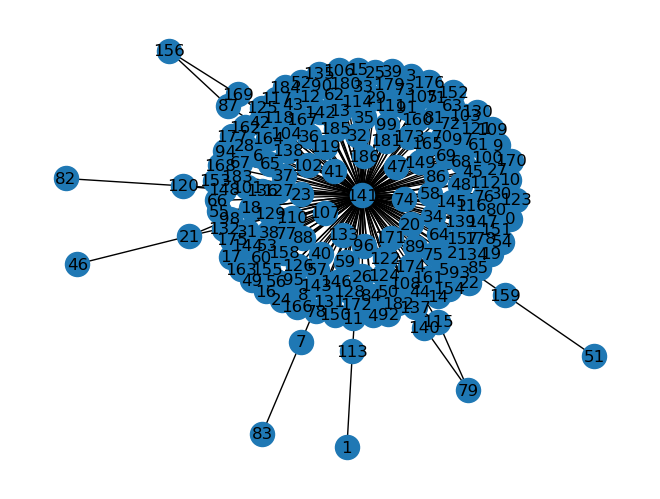

In [29]:
nx.draw(to_networkx(res[1], to_undirected=True), with_labels=True)